In [1]:
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import matplotlib.pyplot as plt

(data_train, label_train), (data_test, label_test) = fashion_mnist.load_data()

data_train = data_train.astype('float32') / 255.
data_test = data_test.astype('float32') / 255.

data = tf.concat([data_train, data_test], axis= 0)
label = tf.concat([label_train, label_test], axis= 0)
print(label.shape)
print(data.shape)

(70000,)
(70000, 28, 28)


In [2]:
indices = tf.squeeze(tf.where(tf.logical_or(tf.equal(label, 4), tf.equal(label, 5))))
filtered_data = tf.gather(data, indices)
filtered_label = tf.gather(label, indices)

In [3]:
filtered_data.shape

TensorShape([14000, 28, 28])

In [4]:
filtered_label = tf.one_hot(filtered_label, depth=10)

In [5]:
from sklearn.model_selection import train_test_split

data_np = filtered_data.numpy()
label_np = filtered_label.numpy()
x_train, x_temp, y_train, y_temp = train_test_split(data_np, label_np, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
x_train.shape

(11200, 28, 28)

In [7]:
x_val.shape

(1400, 28, 28)

In [8]:
x_test.shape

(1400, 28, 28)

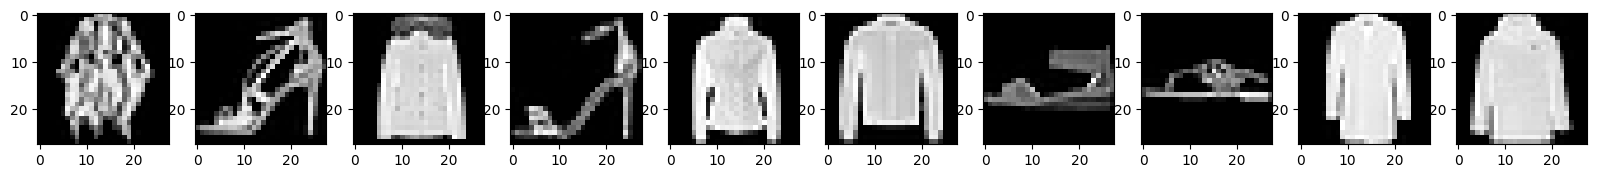

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.image import ssim

input_shape = (28, 28, 1)

# Encoder
encoder_input = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
latent = Dense(128, activation='relu', name='latent')(x)
encoder_model = Model(encoder_input, latent, name='encoder')
encoder_model.summary()

decoder_input = Input(shape=(128,), name='decoder_input')
x = Dense(8*7*7, activation='relu')(decoder_input)
x = Reshape((7, 7, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder_model = Model(decoder_input, decoded_output, name='decoder')
decoder_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           1160

In [11]:
autoencoder_input = encoder_input
autoencoder_output = decoder_model(encoder_model(autoencoder_input))

In [12]:
model = Model(autoencoder_input, autoencoder_output, name='autoencoder')
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 128)               56408     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         52465     
                                                                 
Total params: 108,873
Trainable params: 108,873
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss='binary_crossentropy')
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 128)               56408     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         52465     
                                                                 
Total params: 108,873
Trainable params: 108,873
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train, x_train, batch_size = 32, epochs = 50, shuffle = True, validation_data = (x_val, x_val))


Epoch 1/50
350/350 [==============================] - 6s 8ms/step - loss: 0.3483 - val_loss: 0.2926
Epoch 2/50
350/350 [==============================] - 2s 6ms/step - loss: 0.2845 - val_loss: 0.2824
Epoch 3/50
350/350 [==============================] - 2s 7ms/step - loss: 0.2781 - val_loss: 0.2810
Epoch 4/50
350/350 [==============================] - 2s 6ms/step - loss: 0.2743 - val_loss: 0.2747
Epoch 5/50
350/350 [==============================] - 2s 7ms/step - loss: 0.2717 - val_loss: 0.2754
Epoch 6/50
350/350 [==============================] - 2s 6ms/step - loss: 0.2699 - val_loss: 0.2723
Epoch 7/50
350/350 [==============================] - 2s 6ms/step - loss: 0.2690 - val_loss: 0.2714
Epoch 8/50
350/350 [==============================] - 2s 7ms/step - loss: 0.2673 - val_loss: 0.2687
Epoch 9/50
350/350 [==============================] - 2s 7ms/step - loss: 0.2664 - val_loss: 0.2717
Epoch 10/50
350/350 [==============================] - 2s 6ms/step - loss: 0.2657 - val_loss: 0.2677

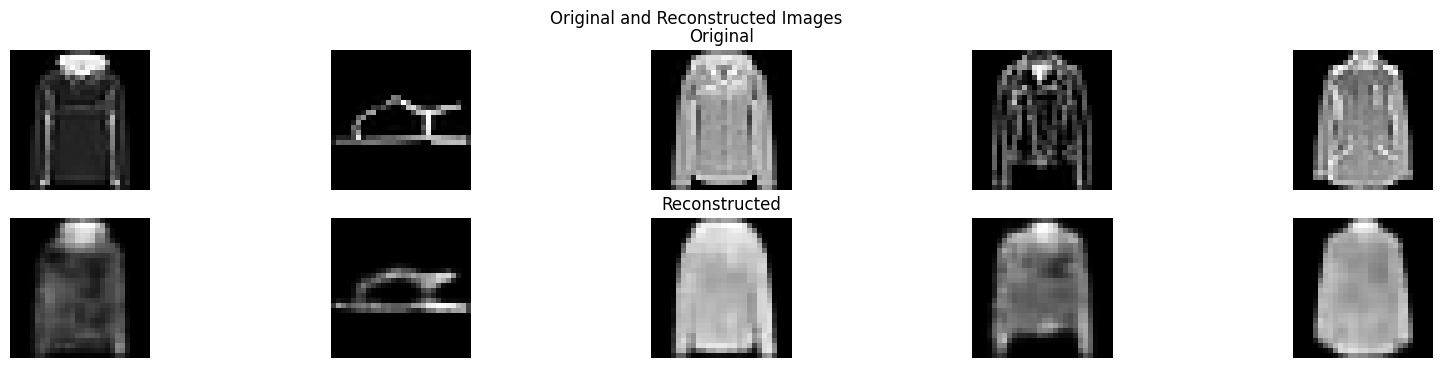

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the reconstructed images
y_pred = model.predict(x_test)

# Number of images to display
num_images = 5

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
fig.suptitle('Original and Reconstructed Images')

for i in range(num_images):
    # Original image
    ax = axes[0, i]
    # Convert EagerTensor to NumPy array before reshaping
    ax.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == num_images // 2:
        ax.set_title("Original")

    # Reconstructed image
    ax = axes[1, i]
    # Convert EagerTensor to NumPy array before reshaping
    ax.imshow(y_pred[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    if i == num_images // 2:
        ax.set_title("Reconstructed")

plt.show()

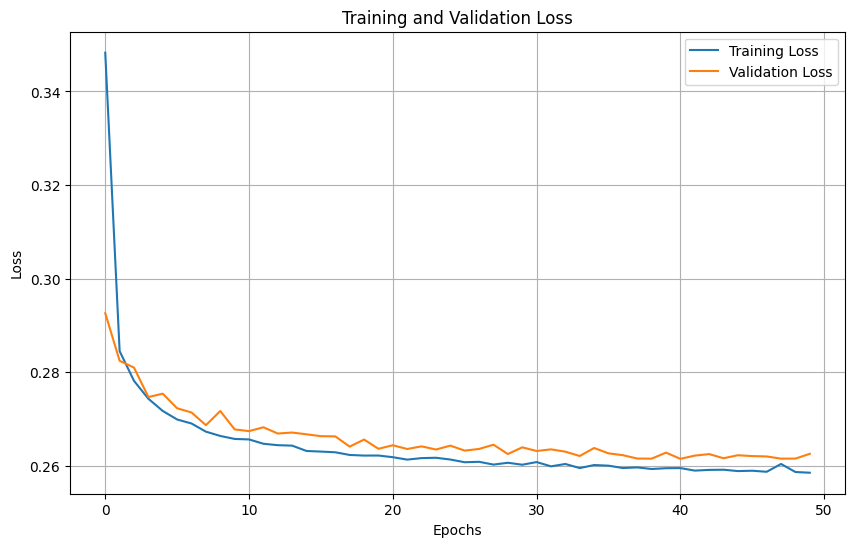

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
from skimage.metrics import structural_similarity

y_pred = model.predict(x_test)

print(f'SSIM : {structural_similarity(x_test.squeeze(), y_pred.squeeze())}')

SSIM : 0.9091673095312358


dari model yang kedua ini bisa kita lihat kalau model tersebut memiliiki proses training dan validasi yang lebih baik dibandingkan model 1. Walaupun model ini memiliki nilai SSIM lebih rendah dibandingkan yang pertama, namun model ini tidak begitu mengalami overfitting seperti yang dialami model pertama

3 alasan yang menurut saya bisa menjadi pertimbangan mengapa model saya bisa lebih baik

1. Secara generalisasi model kedua ini memiliki skor SSM ang lebih rendah namun menunjukkan bahwa model 2 juga mampu merekonstruksi gambar dengan baik pada dataset dan sampelnya tidak hanya pada proses training data saja

2. overfitting problem model 1 memiliki masalah pada overfitting, hanya bagus pada data yang sudah pernah dilihatnya saja atau saat pelatihan saja namun mengakibatkan performanya buruk pada pengaplikasian langsung pada saat testing

3. Skor SSIM, walaupun SSIM menjadi tolak ukur juga pada soal nomor ini, akan tetapi perbedaan pada skor 0.96 dan 0.90 pada model 1 dan model 2 masih berbeda sangat tipis dan masih bisa diterima jika model 2 lebih kuat dan mampu generalisasi dengan baik

kesimpulan saya, model 2 lebih seimbang antara akurasi skor SSIM dalam rekonstruksi data gambar dan kemampuan generalisasinya dalam mengatasi overfitting. Penting juga untuk memprioritaskan model yang lebih konsisten/memiliki tingkat generalisasi yang lebih tinggi walaupun skor hasil prediksi lebih rendah dibandingkan model lainnya, karena kita tidak bisa terpaku pada skor2 seperti akurasi, precision, ssim, roc auc, dll. Jadi saya bisa merekomendasikan model 2 lebih baik dibandingkan model 1 dalam situasi ini